In [1]:
!pip install tensorflow==2.3.0

     |████████████████████████████████| 320.4 MB 43 kB/s 
     |████████████████████████████████| 2.9 MB 35.6 MB/s 
     |████████████████████████████████| 459 kB 41.7 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.utils import class_weight


In [3]:
train_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain'
val_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/ValData'

In [4]:
num_classes_train = len(os.listdir(train_path))
print("There are %d classes in the train dataset." %num_classes_train)

There are 4 classes in the train dataset.


In [5]:
num_classes_val = len(os.listdir(val_path))
print("There are %d classes in the validation dataset." %num_classes_val)

There are 4 classes in the validation dataset.


In [6]:
batch_size = 32
image_size = (299,299)


In [7]:
train_gen = ImageDataGenerator(                                                              
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                preprocessing_function=preprocess_input,
                                fill_mode='nearest'
                               )

In [8]:
train_data = train_gen.flow_from_directory(train_path,                                           
                                            target_size=image_size,                                            
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=True)

Found 2002 images belonging to 4 classes.


In [9]:
num_classes = train_data.num_classes
num_classes

4

In [10]:
## class labels

class_labels = list(train_data.class_indices.keys())
class_labels

['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia']

In [11]:
images, labels = next(train_data)
print(images.shape, labels.shape)

(32, 299, 299, 3) (32,)


In [12]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [13]:
val_data = val_gen.flow_from_directory(val_path,                                       
                                      target_size=image_size,                                      
                                      class_mode='sparse',
                                      batch_size=batch_size,
                                      shuffle=True)

Found 988 images belonging to 4 classes.


In [14]:
## defining the  base InceptionV3 model..

img_shape = image_size + (3,)

basemodel = InceptionV3(include_top=False,
                        weights='imagenet',                                               
                        input_shape=img_shape)

87916544/87910968 [==============================] - 2s 0us/step


In [15]:
basemodel.trainable = False

In [16]:
basemodel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
## constructing a new classification layer on top the base model

x = basemodel.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=basemodel.input, outputs=outputs)    



In [18]:
## compile the model

base_lr = 0.0001

model.compile(optimizer=Adam(lr=base_lr),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [19]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [20]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                classes=np.unique(train_data.classes), 
                y=train_data.classes)

train_class_weights = dict(enumerate(class_weights))

print(train_class_weights)

{0: 0.77, 1: 8.341666666666667, 2: 0.56875, 3: 1.2148058252427185}


In [21]:
init_epoch = 10

history = model.fit_generator(train_data,
                              steps_per_epoch=len(train_data),
                              epochs=init_epoch,
                              validation_data=val_data,
                              validation_steps=len(val_data),
                              class_weight=train_class_weights)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
63/63 [==============================] - 576s 9s/step - loss: 1.0766 - accuracy: 0.5564 - val_loss: 0.6466 - val_accuracy: 0.7470
Epoch 2/10
63/63 [==============================] - 79s 1s/step - loss: 0.7051 - accuracy: 0.6838 - val_loss: 0.6810 - val_accuracy: 0.7024
Epoch 3/10
63/63 [==============================] - 80s 1s/step - loss: 0.6443 - accuracy: 0.7148 - val_loss: 0.6312 - val_accuracy: 0.7399
Epoch 4/10
63/63 [==============================] - 79s 1s/step - loss: 0.5957 - accuracy: 0.7293 - val_loss: 0.5656 - val_accuracy: 0.7551
Epoch 5/10
63/63 [==============================] - 79s 1s/step - loss: 0.5507 - accuracy: 0.7358 - val_loss: 0.5777 - val_accuracy: 0.7540
Epoch 6/10
63/63 [==============================] - 79s 1s/step - loss: 0.5388 - accuracy: 0.7403 - val_loss: 0.5694 - val_accuracy: 0.7409
Epoch 7/10
63/63 [==============================] - 79s 1s/step - loss: 0.5145 - ac

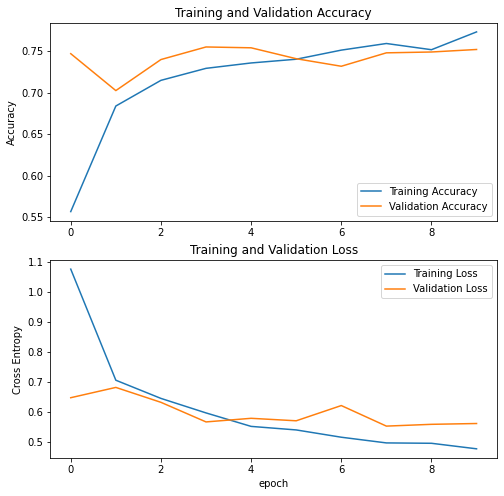

In [22]:
##Let's take a look at the learning curves of the training and validation accuracy/loss when using the InceptionV3 base model as a fixed feature extractor.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
## fine tuning

In [24]:
## lets check how many layers in the Inceptionv3 are trainable..

basemodel.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(basemodel.layers))


Number of layers in the base model:  311


In [25]:
## lets check out the layers by name

for i , layer in enumerate(basemodel.layers):
  print(i, layer.name, layer.trainable)

0 input_1 True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_13 True
45

In [28]:
## lets start fine tune the model from layer 279(mixed 9)

fine_tune_at = 279

for layer in basemodel.layers[:fine_tune_at]:
  layer.trainable = False

for layer in basemodel.layers[fine_tune_at:]:
  layer.trainable = True
                              


In [29]:
## lets recompile the model with even lower learning rate since there are more parameters to learn..

base_lr = 0.00001

model.compile(optimizer=Adam(lr=base_lr),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [30]:
fine_tune_epoch = 35

filepath_checkpoint = 'InceptionV3_model_w_wgts.h5'

checkpoint = ModelCheckpoint(filepath_checkpoint,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=15,
                           mode='max')

callbacks_list = [checkpoint, early_stop]

history_tuned = model.fit_generator(train_data,
                                    steps_per_epoch=len(train_data),
                                    epochs=fine_tune_epoch,
                                    initial_epoch=history.epoch[-1],
                                    shuffle=True,
                                    validation_data=val_data,
                                    validation_steps=len(val_data),                                    
                                    callbacks=callbacks_list,
                                    class_weight=train_class_weights) 

Epoch 10/35
63/63 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.6998
Epoch 00010: val_accuracy improved from -inf to 0.74696, saving model to InceptionV3_model_w_wgts.h5
63/63 [==============================] - 92s 1s/step - loss: 0.6358 - accuracy: 0.6998 - val_loss: 0.5995 - val_accuracy: 0.7470
Epoch 11/35
63/63 [==============================] - ETA: 0s - loss: 0.4703 - accuracy: 0.7717
Epoch 00011: val_accuracy improved from 0.74696 to 0.75607, saving model to InceptionV3_model_w_wgts.h5
63/63 [==============================] - 80s 1s/step - loss: 0.4703 - accuracy: 0.7717 - val_loss: 0.5766 - val_accuracy: 0.7561
Epoch 12/35
63/63 [==============================] - ETA: 0s - loss: 0.4442 - accuracy: 0.7947
Epoch 00012: val_accuracy did not improve from 0.75607
63/63 [==============================] - 77s 1s/step - loss: 0.4442 - accuracy: 0.7947 - val_loss: 0.5721 - val_accuracy: 0.7561
Epoch 13/35
63/63 [==============================] - ETA: 0s - loss:

In [31]:
acc += history_tuned.history['accuracy']
val_acc += history_tuned.history['val_accuracy']

loss += history_tuned.history['loss']
val_loss += history_tuned.history['val_loss']


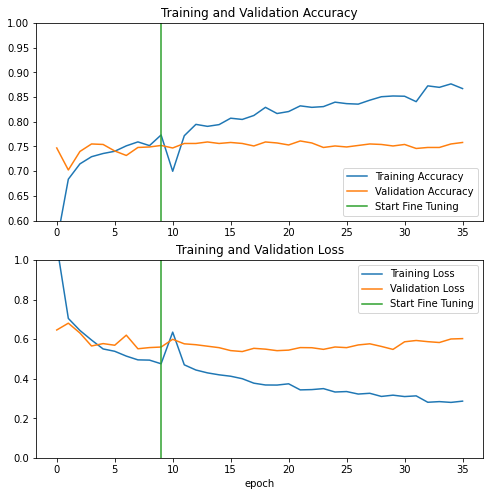

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([init_epoch-1,init_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([init_epoch-1,init_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
## lets load the model which has the best training accuracy

model = keras.models.load_model('InceptionV3_model_w_wgts.h5')

In [34]:
## lets test our model on a new image that was not in train data or validation data
import tensorflow as tf

test_img = keras.preprocessing.image.load_img('/content/drive/MyDrive/Colab Notebooks/data_covid/TrainData/COVID-19/_22_4332598.jpeg', target_size=(299,299)) 
img = keras.preprocessing.image.img_to_array(test_img)
img = preprocess_input(img)
img = tf.expand_dims(img, 0)

prediction = model.predict(img)
score = tf.nn.softmax(prediction[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence."
       .format(class_labels[np.argmax(score)], 100*np.max(score))      
      )

This image most likely belongs to COVID-19 with a 46.80 percent confidence.


In [35]:
## lets get the classification report..

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(val_path,
                                       target_size=image_size,
                                       class_mode='sparse',
                                       batch_size=batch_size,
                                       shuffle=False)

test_steps_per_epoch = len(test_ds)

predictions = model.predict_generator(test_ds, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_ds.classes
test_class_labels = list(test_ds.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=test_class_labels)
print(report)    


Found 988 images belonging to 4 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
                    precision    recall  f1-score   support

BacterialPneumonia       0.64      0.81      0.72       324
          COVID-19       0.86      0.67      0.75         9
            Normal       0.89      1.00      0.94       450
    ViralPneumonia       0.51      0.16      0.24       205

          accuracy                           0.76       988
         macro avg       0.72      0.66      0.66       988
      weighted avg       0.73      0.76      0.72       988



In [36]:
## lets plot the confusion matrix

In [37]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot   

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    #import matplotlib.pyplot as plt
    #import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

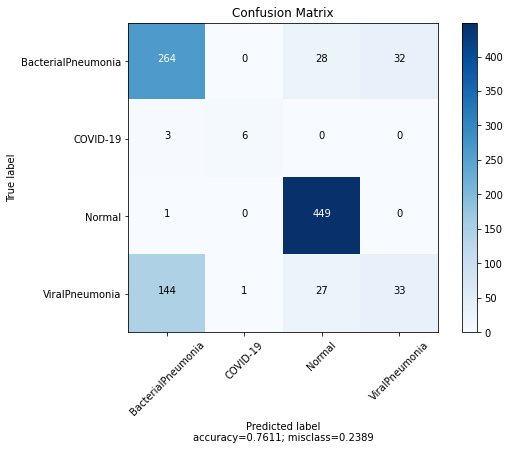

In [38]:
prediction = model.predict_generator(test_ds)
y_pred = np.argmax(prediction, axis=1)

cm = confusion_matrix(true_classes, y_pred)

plot_confusion_matrix(cm,          
                      normalize    = False,
                      target_names = test_class_labels,
                      title        = "Confusion Matrix")